# Dataset Analysis & CNN Model Optimization for Plant Disease Classification

In [8]:
!ls ./dataset

classes_split
images
plant-pathology-2020-fgvc7.zip
sample_submission.csv
split_images
test.csv
train.csv


## Train, Validation, Test Split
- divide the provided dataset into training, validating, testing data
- How to properly install tensorflow to anaconda jupyter notebook: https://stackoverflow.com/questions/43216256/running-tensorflow-in-jupyter-notebook/45840060

In [13]:
import os
import shutil

src_dir = "dataset/images"
train_val_split_dir = "dataset/split_images/train_val_images"
test_split_dir = "dataset/split_images/test_images"

# Create folders
if not os.path.isdir(train_val_split_dir):
    os.mkdir(train_val_split_dir)
if not os.path.isdir(test_split_dir):
    os.mkdir(test_split_dir)

# Split datasets
if len([f for f in os.listdir(test_split_dir)]) == 0:
    all_images_names = os.listdir(src_dir)
    train_val_images = []
    test_images  = []
    for image in all_images_names:
        if "Train" in image:
            shutil.copy(src_dir + "/" + image, train_val_split_dir)
        elif "Test" in image:
            shutil.copy(src_dir + "/" + image, test_split_dir)
        else:
            print("Error in splitting datasets")
    
# Check for possible errors
total = len([f for f in  os.listdir(src_dir)])
train_val_total = len([f for f in  os.listdir(train_val_split_dir)])
test_total = len([f for f in  os.listdir(test_split_dir)])
print(total == train_val_total + test_total)

True


## Import Modules

In [13]:
# INSTALL
# Latest version of tensorflow, which comes with useful image loading APIs
!pip install tf-nightly  # run only once per session

# IMPORT

## Magic commands for interactivity
%pylab inline                 

## Basic Utilities  
import sys                    # Enabler of operating system dependent functionality
import os                     # Provides access to some variables & functions for the interpreter
import shutil                 # Provides high-level operations on files and collections of files
from shutil import copyfile   # Import module we'll need to import our custom module
import math                   # Provides access to basic mathematical functions
import time                   # Provides various time-related functions
import glob                   # Pathnames management
from PIL import Image as pil_image
import itertools

## Data Manipulation & Analysis
import pandas as pd           # Methods to manipulate, filter, group, and transform data
import numpy as np            # Efficient storage and computation for multi-dimensional data arrays
from numpy import expand_dims

## Data Visualization 
import matplotlib             # Interface for creation of publication-quality plots and figures
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import seaborn as sns         # Matplotlib-based statistical data visualization interface 
### import plotly             # Interactive plotting library 
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

## Machine Learning 
### Scikit-Learn
from sklearn.model_selection import train_test_split # Split arrays or matrices into random train and test subsets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA, TruncatedSVD # Principal component analysis (PCA); dimensionality reduction using truncated SVD.
### TensorFlow
import tensorflow as tf

from tensorflow.python.keras import layers
import tensorflow.keras.backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.regularizers import l2
import tensorflow.python.keras.layers as L
from tensorflow.keras.applications import DenseNet121
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam , RMSprop
### SMOTE
from imblearn.over_sampling import SMOTE # Class Balancing

print("Complete import")

Populating the interactive namespace from numpy and matplotlib
Complete import


ERROR: Invalid requirement: '#'
C:\Users\nguye\AppData\Roaming\Python\Python37\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
import tensorflow as tf
print(tf.__version__)

2.6.0-dev20210618


## Data Exploration

In [15]:
four_classes_split_dir = "dataset/four_classes_split_images" # Folder store split to 4 types of plants
dataset_dir = "dataset"


train_labels_csv = pd.read_csv(dataset_dir + "/train.csv")
print(train_labels_csv.head())

print("-------------------------------------")
example_submission_csv = pd.read_csv(dataset_dir+"/sample_submission.csv")
print(example_submission_csv.head() )

print("-------------------------------------")
test_dir = dataset_dir + "/split_images/test_images"
test_csv = pd.read_csv(dataset_dir+"/test.csv")
test_paths_csv= pd.DataFrame(test_csv["image_id"].apply(lambda x: test_dir+"/"+x+".jpg"))
print(test_paths_csv.head() )

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
-------------------------------------
  image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25
-------------------------------------
                                      image_id
0  dataset/split_images/test_images/Test_0.jpg
1  dataset/split_images/test_images/Test_1.jpg
2  dataset/split_images/test_images/Test_2.jpg
3  dataset/split_images/test_images/Test_3.jpg
4  dataset/split_images/test_images/Test_4.jpg


## Train, Validation Splitting 4 Categories from train_val_dataset
- The following cell creates four directories healthy, multiple_diseases, rust, scab with the corresponding images from the train dataset. It is a very technical part due to the way the images need to be organized for TensorFlow.
- If you want to rerun this script the delete dataset/four_classes_split_image.train

In [19]:
# Create csv files with images
train_val_healthy_csv = train_labels_csv[train_labels_csv["healthy"] == 1]
train_val_multiple_diseases_csv  = train_labels_csv[train_labels_csv["multiple_diseases"] == 1]
train_val_rust_csv = train_labels_csv[train_labels_csv["rust"] == 1]
train_val_scab_csv = train_labels_csv[train_labels_csv["scab"] == 1]

# We will check that this has no entry
two_classes = train_labels_csv[(train_labels_csv["scab"] == 1) & (train_labels_csv["multiple_diseases"] == 1)]

train_val_healthy_names = train_val_healthy_csv["image_id"].tolist()
train_val_multiple_diseases_names = train_val_multiple_diseases_csv["image_id"].tolist()
train_val_rust_names = train_val_rust_csv["image_id"].tolist()
train_val_scab_names = train_val_scab_csv["image_id"].tolist()

src_dir = "dataset/split_images/train_val_images"
train_split_dir = four_classes_split_dir+"/train" 

# val_split_dir = four_classes_split_dir + "val" 
train_split_healthy_dir = four_classes_split_dir+"/train/healthy"
train_split_multiple_diseases_dir =four_classes_split_dir+"/train/multiple_diseases"
train_split_rust_dir = four_classes_split_dir+"/train/rust"
train_split_scab_dir = four_classes_split_dir+"/train/scab"

test_split_dir = four_classes_split_dir + "test_image/test"

# Create and fill the directories
try:
    os.mkdir(train_split_dir)

    os.mkdir(train_split_healthy_dir)
    os.mkdir(train_split_multiple_diseases_dir)
    os.mkdir(train_split_rust_dir)
    os.mkdir(train_split_scab_dir)
    os.makedirs(test_split_dir)

    for image in train_val_healthy_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_split_healthy_dir)
            
    for image in train_val_multiple_diseases_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_split_multiple_diseases_dir)

    for image in train_val_rust_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_split_rust_dir)

    for image in train_val_scab_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_split_scab_dir)

    for image in test_paths_csv["image_id"].tolist():
        shutil.copy(image,test_split_dir)
        
except FileExistsError as err:
    print("folders already exist")
 
# Check for possible errors
total = len([f for f in  os.listdir(src_dir)])
train_healthy_total = len([f for f in  os.listdir(train_split_healthy_dir)])
train_multiple_diseases_total = len([f for f in  os.listdir(train_split_multiple_diseases_dir)])
train_rust_total = len([f for f in  os.listdir(train_split_rust_dir)])
train_scab_total = len([f for f in  os.listdir(train_split_scab_dir)])

total = train_healthy_total + train_multiple_diseases_total +train_rust_total+ train_scab_total 
train_size = math.ceil(total*0.8)
val_size = total - train_size
test_size = test_csv.size 
image_size  = (200,200)
batch_size = 32
seed = 100
print(train_healthy_total,train_multiple_diseases_total,train_rust_total,train_scab_total,)

516 91 622 592


## Class Balancing & Data Augmentation / Preprocessing
- The function create_augmented_data performs class balancing with SMOTE and data augmentation with ImageDataGenerator by TensorFlow.
- I have tried multiple variants of SMOTE and ImageDataGenerator and selected the following configuration as optimal taking the performance into account.
- Please notice that the function is split in two by the valid parameter: it allows to apply the function to output both the train and validation data together and just the train .

In [24]:
def create_augmented_data(train_split_dir , train_generator, val_generator, aug, batch_size, valid = True):
    if valid:
        # Load data into tensorflow dataset: if we used the flow_form_directory method of the train_generator, 
        ## it would have been  too slow
        print("\nLoading data..........................................")
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            train_split_dir,
            validation_split=0.2,
            subset="training",
            seed=1337,
            image_size=image_size,
            batch_size=train_size, 
        )

        val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            train_split_dir,
            validation_split=0.2,
            subset="validation",
            seed=1337,
            image_size=image_size,
            batch_size=val_size,
        )
        
        print("\nAugmenting train..........................................")
        res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
        x_train = np.array(res[0])
        print("\nFeature augmentation done\n")
        y_train = np.array(res[1])
        yforpca = y_train
        print(x_train.shape,y_train.shape)
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("\nClass distribution before smote = ", counts)
        x_train  = np.array([image.flatten() for image in x_train ])
        xforpca = x_train
        print("\nFlattened\n")

        smote_train = SMOTE(sampling_strategy = "all", random_state = 420,k_neighbors=10,n_jobs=4) # svmsmote goes out of memory in all configs
        x_train, y_train = smote_train.fit_resample(x_train, y_train)
        x_train = np.reshape(x_train,(-1,200,200,3))
        tot_train = len(x_train)
        print("\nTotal_train after smote = ", x_train.shape)
        yforpca1 = y_train #
        xforpca1 = x_train  #
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("\nClass distribution after smote = ", counts)
        y_train_cat = tf.keras.utils.to_categorical(
            y_train, num_classes=4, dtype='float32'
        )
        
        
        train_generator.fit(x_train, seed = seed)
        aug_train_images, aug_train_labels = train_generator.flow(x = x_train,y = y_train_cat,shuffle = False,batch_size = tot_train,seed = seed).next() 
        aug_train_images = np.array(aug_train_images)
        aug_train_labels = np.array(aug_train_labels)
        
        # Save memory
        del x_train
        #del y_train
        del train_ds

        out_train_datagen = ImageDataGenerator()
        out_train_datagen.fit(aug_train_images)
        out_train_flow = out_train_datagen.flow(aug_train_images,aug_train_labels,batch_size = batch_size,shuffle = False)

        del aug_train_images
        del aug_train_labels

        print("\nTrain augmented, augmenting val..........................................")
        #i = 0
        res = list(zip(*val_ds.unbatch().as_numpy_iterator()))
        x_val = np.array(res[0])
        y_val = np.array(res[1])
        y_val_cat = tf.keras.utils.to_categorical(
            y_val, num_classes=4, dtype='float32'
        )
        print(x_val.shape,y_val.shape,y_val_cat.shape)
        
        
        val_generator.fit(x_val)
        aug_val_images, aug_val_labels = val_generator.flow(x = x_val,y = y_val_cat,shuffle = False,batch_size = val_size,seed = seed).next()
        aug_val_images = np.array(aug_val_images)
        aug_val_labels = np.array(aug_val_labels)

        del x_val
        del val_ds

        out_val_datagen = ImageDataGenerator()
        out_val_datagen.fit(aug_val_images)
        out_val_flow = out_val_datagen.flow(aug_val_images,aug_val_labels,batch_size = val_size, shuffle = False)

        del aug_val_images
        del aug_val_labels
        del res

        print("\nReturning\n")
        return (out_train_flow,out_val_flow,y_val,y_train,tot_train)
    # If validation is not provided / one intends to test
    else:
        print("\nLoading data..........................................")
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            train_split_dir,
            seed=1337,
            image_size=image_size,
            batch_size=train_size, 
        )
        
        print("\nAugmenting train..........................................")
        res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
        x_train = np.array(res[0])
        y_train = np.array(res[1])
        print(x_train.shape,y_train.shape)
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("\nClass distribution before smote = ", counts)
        x_train  = np.array([image.flatten() for image in x_train ])
        print("\nFlattened\n")
        yforpca = y_train 
        xforpca = x_train  
        smote_train = SMOTE(sampling_strategy = "all", random_state = 420,k_neighbors=10,n_jobs=4)
        x_train, y_train = smote_train.fit_resample(x_train, y_train)
        x_train = np.reshape(x_train,(-1,200,200,3))
        yforpca1 = y_train 
        xforpca1 = x_train 
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("\nClass distribution after smote = ", counts)
        tot_train = len(x_train)
        print("\nTotal_train after smote = ", x_train.shape)
        
        y_train_cat = tf.keras.utils.to_categorical(
            y_train, num_classes=4, dtype='float32'
        )   

        train_generator.fit(x_train,seed = seed)
        aug_train_images, aug_train_labels = train_generator.flow(x = x_train,y = y_train_cat,shuffle = False,batch_size = tot_train,seed = seed).next()
        aug_train_images = np.array(aug_train_images)
        aug_train_labels = np.array(aug_train_labels)

        del x_train
        del y_train
        del train_ds

        out_train_datagen = ImageDataGenerator()
        out_train_datagen.fit(aug_train_images)
        out_train_flow = out_train_datagen.flow(aug_train_images,aug_train_labels,batch_size = batch_size,shuffle = False)

        del aug_train_images
        del aug_train_labels
        
        return (out_train_flow,tot_train,xforpca,yforpca,xforpca1,yforpca1)

## Test Set Preprocessing
- The test set is preprocessed just as the validation set, in order to give the model the same feature distribution.



In [25]:
def get_augmented_test(test_dir, test_generator):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        outdir + "test_image",
        labels="inferred",
        label_mode="int",
        class_names=None,
        color_mode="rgb",
        batch_size=test_size,
        image_size=image_size,
        shuffle = False,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation="bilinear",
        follow_links=False,
    )
    
    x_test = np.array([ array for array, label in test_ds.unbatch().as_numpy_iterator()])
    test_generator.fit(x_test,seed = seed)
    test_flow = test_generator.flow(
        x= x_test,
        y=None,
        batch_size = test_size,
        shuffle=False,seed = seed)

    test_imgs = test_flow.next()

    del test_ds
    del x_test
    del test_generator

    return test_imgs

## Data Generators
- It's important to stress the difference between data preprocessing and data augmentation:
    - preprocessing refers to a well defined transformation applied to all data (in order to save memory, speed up execution, etc...)
    - augmentation refers to a random modification applied to a random sample of the data to train a more rubust model.
    
- Therefore (selected) augmentation techniques are applied to train only, while validation and test sets receive just the preprocessing applied to train.

In [26]:
# TRAIN
train_datagen = ImageDataGenerator(rotation_range=360,                # DATA AUGMENTATION
                                   #shear_range=.25,                  # DATA AUGMENTATION
                                   #zoom_range=.25,                   # DATA AUGMENTATION
                                   #width_shift_range=.25,            # DATA AUGMENTATION
                                   #height_shift_range=.25,           # DATA AUGMENTATION
                                   rescale=1./255,                    # DATA MODIFICATION
                                   #brightness_range=[.5,1.5],        # DATA AUGMENTATION
                                   horizontal_flip=True,              # DATA AUGMENTATION
                                   #vertical_flip=True                # DATA AUGMENTATION
                                  )

# VALIDATION
val_datagen = ImageDataGenerator(rescale=1./255)

# TEST
test_datagen = ImageDataGenerator(rescale=1./255)

# To train and validate
train_flow_80, val_flow, y_val, y_train,total_train_80 = create_augmented_data(train_split_dir  = train_split_dir,train_generator = train_datagen, val_generator = val_datagen , aug = 5, batch_size = batch_size )
train_flow,total_train,x,y,xS,yS = create_augmented_data(train_split_dir  = train_split_dir,train_generator = train_datagen, val_generator = val_datagen , aug = 5, batch_size = 32, valid = False )


Loading data..........................................
Found 1821 files belonging to 4 classes.
Using 1457 files for training.
Found 1821 files belonging to 4 classes.
Using 364 files for validation.

Augmenting train..........................................

Feature augmentation done

(1457, 200, 200, 3) (1457,)

Class distribution before smote =  [407  74 501 475]

Flattened


Total_train after smote =  (2004, 200, 200, 3)

Class distribution after smote =  [501 501 501 501]

Train augmented, augmenting val..........................................
(364, 200, 200, 3) (364,) (364, 4)

Returning


Loading data..........................................
Found 1821 files belonging to 4 classes.

Augmenting train..........................................
(1821, 200, 200, 3) (1821,)

Class distribution before smote =  [516  91 622 592]

Flattened


Class distribution after smote =  [622 622 622 622]

Total_train after smote =  (2488, 200, 200, 3)


## Sigular Value Decomposition (SVD) & Principal Component Analysis (PCA)

### SVD

- Plot the projection of the train+test sets on the plane defined by the two directions with largest variance, before and after the application of SMOTE.



Text(0.5, 1.0, 'post_SMOTE')

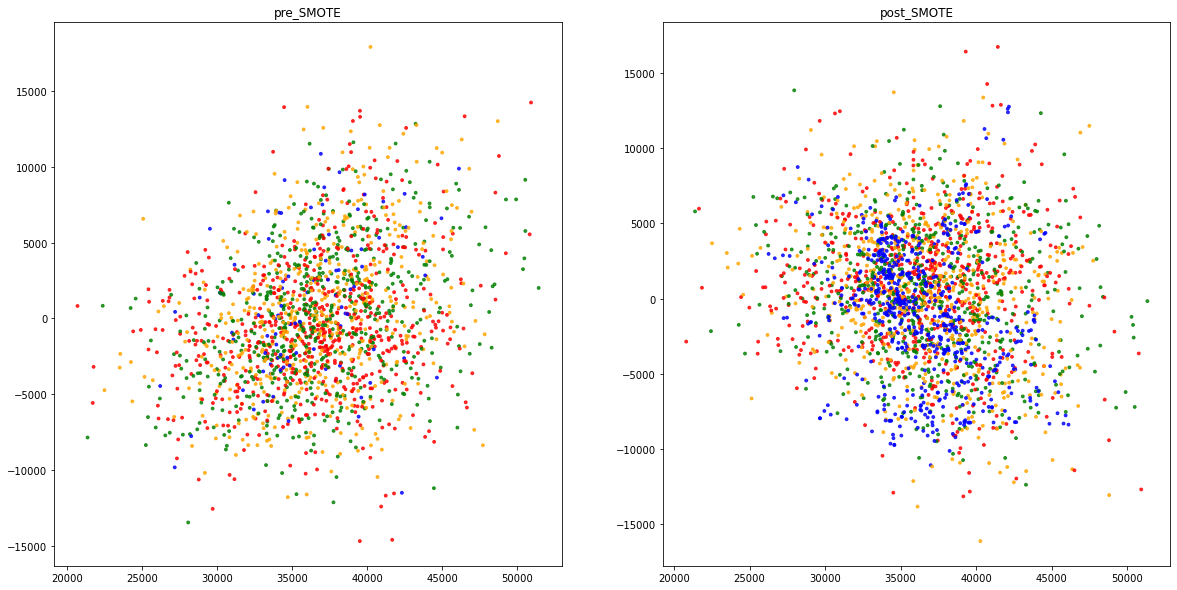

In [27]:
def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ["orange","blue","red","green"]
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            #plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})

x_train  = np.array([image.flatten() for image in x ])
x_trainS  = np.array([image.flatten() for image in xS ])

del x,xS

fig = plt.figure(figsize=(20,10))
fig.add_subplot(121)
plot_LSA(x_train, y)
plt.title("pre_SMOTE")
fig.add_subplot(122)
plot_LSA(x_trainS, yS)
plt.title("post_SMOTE")

### PCA
- Although the two plots above show that the dataset (assuming its signal to be greater than noise) does not live on a linear submanifold, we've decided to plot its principal components below.



U.shape =  (2488, 2488)
S.shape =  (2488,)
V.shape =  (2488, 120000)
plot the first principal components
plot less relevant principal components


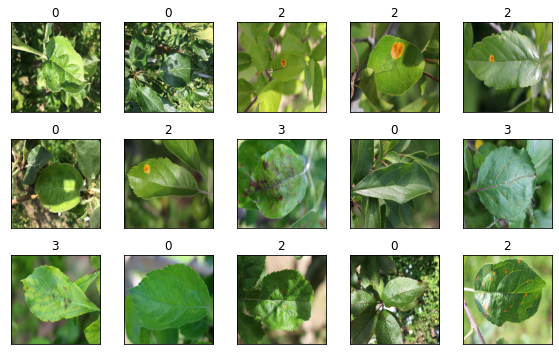

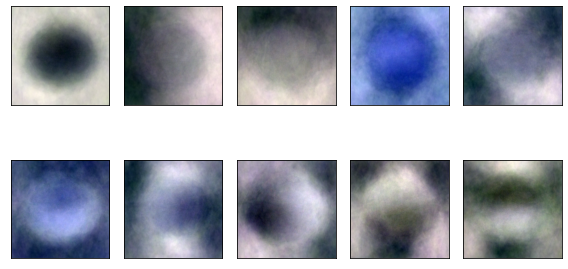

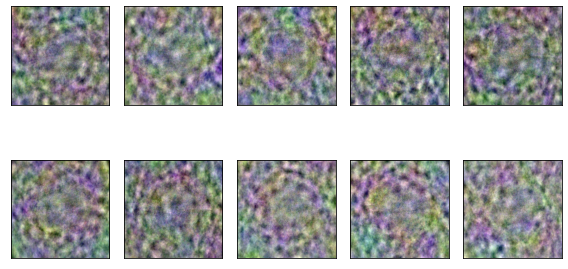

In [28]:
pca = PCA()
pca.fit(x_trainS)

U = pca.transform(x_trainS)
S = pca.explained_variance_
V = pca.components_

print ("U.shape = ", U.shape)
print ("S.shape = ",S.shape)
print ("V.shape = ", V.shape)

plt.rc("image", cmap="binary")
plt.figure(figsize=(8,5))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(x_train[i].reshape(200,200,3)))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()


print("plot the first principal components")

plt.figure(figsize=(8,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(V[i].reshape(200,200,3)))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()


print("plot less relevant principal components")
plt.figure(figsize=(8,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(V[200+i].reshape(200,200,3)))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

### Explained Variance
- Here we plot the explained variance as a function of the principal directions retained.


429


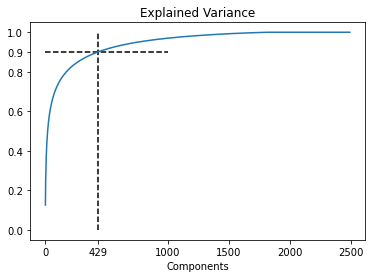

In [29]:
ev_cumsum = np.cumsum(pca.explained_variance_)/(pca.explained_variance_).sum()
ev_at90 = ev_cumsum[ev_cumsum<0.9].shape[0]
print (ev_at90)

plt.plot(ev_cumsum)
plt.title("Explained Variance")
plt.xlabel("Components")
plt.xticks([0, ev_at90, 1000, 1500, 2000, 2500])
plt.yticks(list(plt.yticks()[0]) + [0.9])
plt.vlines(ev_at90, 0, 1, linestyles='dashed')
plt.hlines(0.9, 0, 1000, linestyles='dashed');